In [1]:
import os
import sys
import numpy as np
import scipy.spatial.distance as dis
import scipy.stats as st
import time

from glob import glob
from gesture_comparison_helper import load_gestures
from itertools import combinations_with_replacement, product
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt

In [2]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from Utils.data_preparation_helper import load_data_for_classification, prepare_data

c:\python36\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
random_seed = 42

np.random.seed(random_seed)

In [9]:
def calculate_similarity(a, b, sim_type):
    if sim_type == 'cosine':
        return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    elif sim_type == 'euclid':
        return 1/(1+dis.euclidean(a, b))
    elif sim_type == 'pearson':
        return st.pearsonr(a, b)[0]
    else:
        print('sim_type value "{}" is not supported, choose cosine, eucild or pearson instead'.format(sim_type))

def calculate_distance(a, b, dist_type):
    if dist_type == 'cosine':
        return 1 - np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))
    elif dist_type == 'euclid':
        return dis.euclidean(a, b)
    elif dist_type == 'pearson':
        return 1 - st.pearsonr(a, b)[0]
    else:
        print('dist_type value "{}" is not supported, choose cosine, eucild or pearson instead'.format(dist_type))
        
def print_confusion_matrix_colored(confusion_matrix, c_labels, xy_labelsize, c_labelsize, save=None):
    fig = plt.figure(figsize=(10,10))
    ax  = fig.add_subplot(111)
    #ax.set_title('Ähnlichkeitsmatrix', fontsize=xy_labelsize)
    #ax.set_xlabel('prädizierte Klasse', fontsize=xy_labelsize, labelpad=12)
    ax.xaxis.tick_top()
    ax.set_xticks(list(range(len(c_labels))))
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_ticklabels(c_labels, fontsize=c_labelsize, rotation=90)

    #ax.set_ylabel('tatsächliche Klasse', fontsize=xy_labelsize)
    ax.yaxis.set_ticklabels(c_labels, fontsize=c_labelsize)
    ax.set_yticks(list(range(len(c_labels))))

    img = ax.imshow(confusion_matrix, cmap='gray')
    cbar = fig.colorbar(img)
    cbar.ax.tick_params(labelsize=c_labelsize)
    fig.tight_layout()
    if save != None:
        fig.savefig(save)
    plt.show()

In [5]:
own = ['big_stop', 'come_down', 'come_here', 'come_up', 'flip', 'small_stop']
paper = ['hcwh', 'hcwv', 'hcws',
         'hcch', 'hccv', 'hccs',
         'tcwh', 'tcwv', 'tcws',
         'tcch', 'tccv', 'tccs',
         'lcwh', 'lcwv', 'lcws',
         'lcch', 'lccv', 'lccs']

acc_frames = 3
gyro_frames = 12
ori_frames = 2
emg_frames = 11

similarity = 'cosine'

In [6]:
start_time = time.time()
gesture_dicts = [load_gestures(glob('../Data/converted/*/' + gesture + '/*')) for gesture in own+paper]

prepared_groups = []
for gesture_group in gesture_dicts:
    gesture = []
    gesture.append(prepare_data(gesture_group, acc_frames, 'accelerometer', verbose=False)[0])
    gesture.append(prepare_data(gesture_group, gyro_frames, 'gyro', verbose=False)[0])
    gesture.append(prepare_data(gesture_group, emg_frames, 'emg', verbose=False)[0])
    gesture.append(prepare_data(gesture_group, ori_frames, 'orientation', verbose=False)[0])
    prepared_groups.append(gesture)
        
print('Duration: {}'.format(time.time() - start_time))

Duration: 566.6372203826904


In [7]:
row_length = len(own+paper)

similarity_matrix = []
sim_mat_row = []

for gesture, gesture_label in zip(product(prepared_groups, repeat=2), product(own+paper, repeat=2)):
    
    #print('{} to {}'.format(gesture_label[0], gesture_label[1]))
    sensor_mean = []
    
    for sensortype_ga, sensortype_gb in zip(gesture[0], gesture[1]):
        
        mean_a = np.divide(np.sum(sensortype_ga, axis=0), len(sensortype_ga))
        mean_b = np.divide(np.sum(sensortype_gb, axis=0), len(sensortype_gb))
        
        sensor_mean.append(calculate_similarity(mean_a, mean_b, sim_type=similarity))
        
    sim_mat_row.append(np.mean(sensor_mean))
    
    if len(sim_mat_row) == row_length:
        similarity_matrix.append(sim_mat_row)
        sim_mat_row = []

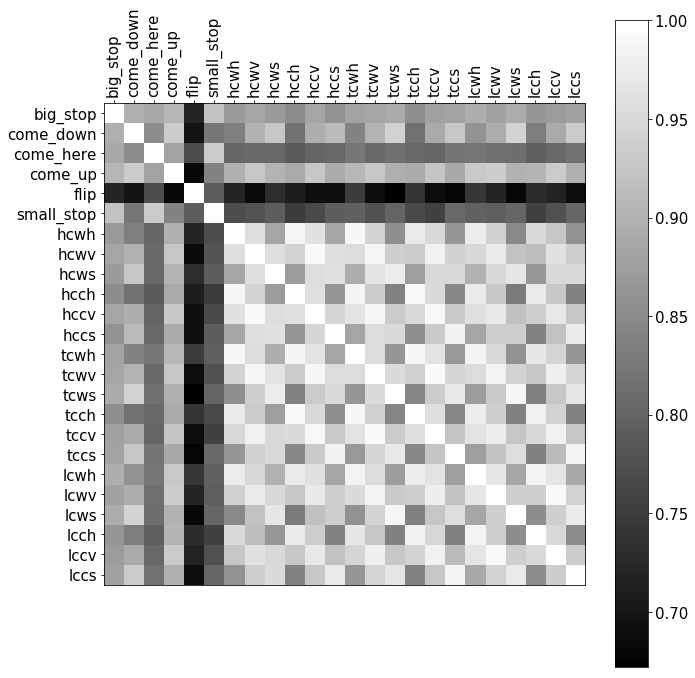

In [11]:
#print(similarity_matrix)

print_confusion_matrix_colored(similarity_matrix, own+paper, 20, 15)